# MCBU CH4 plumes data analysis

## Import libraries

In [45]:
import os
import datetime
import json
import shutil

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
from arcgis.features import GeoAccessor
import contextily as cx

#https://towardsdatascience.com/how-to-set-up-anaconda-and-jupyter-notebook-the-right-way-de3b7623ea4a

## Connect to MapHub

In [74]:
gis = GIS("https://maphub-amer.tst.azure.chevron.com/portal", client_id='bb6vn14P957pN6bV')
print("Logged in as: " + gis.properties.user.username)

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://maphub-amer.tst.azure.chevron.com/portal/sharing/rest//oauth2/authorize?response_type=code&client_id=bb6vn14P957pN6bV&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=gtUSbQcge43xhAwaoGhPx8HzC6iFg0
Enter code obtained on signing in using SAML: ········


C:\Users\ekqo\Miniconda3\envs\arcgis\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maphub-amer.tst.azure.chevron.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Logged in as: ekqo


## Search for layers

In [47]:
# Search for Feature Layers owned by the logged-in user
my_content = gis.content.search(query="owner:" + gis.users.me.username, 
                                item_type="Feature Layer", 
                                max_items=15)

#my_content

## Access group and show contents

In [49]:
ch4_mcbu_group = gis.groups.search('title:MCBU_CH4', max_groups=15)
ch4_mcbu_group = ch4_mcbu_group[0]
#gis.groups.get(ch4_mcbu_group.groupid)
#ch4_mcbu_group.content()

## Load the plumes data into a gdf

In [50]:
# Plumes data title
title = 'Fall 2021 Plumes detected by GAO - Carbon Mapper'

# Search for the plumes data by title
plumes_id = gis.content.search(query='title:' + title,
                               item_type='Feature Layer',
                               max_items=1)

# Get the plumes data using the itemid
plumes_data = gis.content.get(plumes_id[0].itemid).layers[0]

# .query() returns a FeatureSet
fset = plumes_data.query()

# get a GeoJSON string representation of the FeatureSet
gjson_string = fset.to_geojson

# read GeoJSON string into a dict
gjson_dict = json.loads(gjson_string)

# Read the dict into a gdf
plumes_gdf = gpd.GeoDataFrame.from_features(gjson_dict['features'])

# Set the CRS
plumes_gdf = plumes_gdf.set_crs(epsg=3857)
#plumes_gdf

## Load the field outlines into a gdf

In [51]:
# Title for fields data
title = 'COMM_MCBU_OPS_FOT_OUTLINE'

# Search for the plumes data by title
fields_id = gis.content.search(query='title:' + title,
                               item_type='Feature Layer',
                               max_items=35)

# Get the plumes data using the itemid
fields_data = gis.content.get(fields_id[0].itemid).layers[0]

# .query() returns a FeatureSet
fset = fields_data.query()

# get a GeoJSON string representation of the FeatureSet
gjson_string = fset.to_geojson

# read GeoJSON string into a dict
gjson_dict = json.loads(gjson_string)

# Read the dict into a gdf
fields_gdf = gpd.GeoDataFrame.from_features(gjson_dict['features'])

# Set the CRS
fields_gdf = fields_gdf.set_crs(epsg=4267)
#fields_gdf

## Unify projections

In [53]:
# Reproject the plumes
plumes_gdf = plumes_gdf.to_crs(epsg=4267)
plumes_gdf.head()

,geometry,OBJECTID,source_id,plume_lat,plume_lon,plume_candidate_id,date_of_detection,time_of_detection,source_type,source_type_label,ipcc,qplume,sigma_qplume,active_flare,inactive_flare,Operator_Alias,imageurl,County,State
0,POINT (-104.15381 32.09789),9827,F21P_0001,32.098010,-104.15430,GAO20211003t155009p0000-A,1633219200000,15:50:09,well,Production,1B2 Oil & Natural Gas,237.703647,70.335432,None,None,CHEVRON USA,https://edf-permian-data.s3.amazonaws.com/imag...,Eddy,New Mexico
1,POINT (-104.11624 32.14868),9828,F21P_0002,32.148804,-104.11673,GAO20211003t155009p0000-B,1633219200000,15:50:09,tank,Production,1B2 Oil & Natural Gas,488.323421,223.227806,None,None,OCCIDENTAL PETROLEUM COMPANY,https://edf-permian-data.s3.amazonaws.com/imag...,Eddy,New Mexico
2,POINT (-104.07447 32.16987),9829,F21P_0003,32.169991,-104.07496,GAO20211003t155009p0000-C,1633219200000,15:50:09,compressor,Gathering & Boosting,1B2 Oil & Natural Gas,582.313511,172.122195,None,None,SENDERO MIDSTREAM,https://edf-permian-data.s3.amazonaws.com/imag...,Eddy,New Mexico
3,POINT (-103.98457 32.22599),9830,F21P_0004,32.226113,-103.98506,GAO20211003t155009p0000-D,1633219200000,15:50:09,compressor,Gathering & Boosting,1B2 Oil & Natural Gas,720.878562,199.999978,None,None,DCP MIDSTREAM PARTNERS,https://edf-permian-data.s3.amazonaws.com/imag...,Eddy,New Mexico
4,POINT (-103.97398 32.22132),9831,F21P_0005,32.221445,-103.97447,GAO20211003t155009p0000-E,1633219200000,15:50:09,compressor,Gathering & Boosting,1B2 Oil & Natural Gas,666.558008,262.897112,None,None,ENTERPRISE PRODUCTS,https://edf-permian-data.s3.amazonaws.com/imag...,Eddy,New Mexico


## Clip plumes to field outlines 

In [55]:
# Use spatial join to clip points to field outlines
plumes_gdf_clipped = gpd.sjoin(plumes_gdf, fields_gdf, how='inner')

# Rename lat/long
plumes_gdf_clipped.rename(columns={'plume_lat': 'Lat', 'plume_lon': 'Long'}, inplace=True)
plumes_gdf_clipped.head()

,geometry,OBJECTID_left,source_id,Lat,Long,plume_candidate_id,date_of_detection,time_of_detection,source_type,source_type_label,...,MCBU_GIS_SOURCE_NAME,MCBU_GIS_DATA_RECEIVED_DATE,MCBU_GIS_DATA_UPLOADED_DATE,MCBU_GIS_DATA_MODIFIED_DATE,MCBU_GIS_DATA_MODIFIED_BY,MCBU_GIS_DATA_REMARK,CURRENT_INDICATOR_LF,MCBU_GIS_OPS_CONTACT,SHAPE.STArea(),SHAPE.STLength()
2,POINT (-104.07447 32.16987),9829,F21P_0003,32.169991,-104.07496,GAO20211003t155009p0000-C,1633219200000,15:50:09,compressor,Gathering & Boosting,...,MCBU Production Reporting (MPR),1631664000000,1632096000000,1632096000000,Janice Fisher (KCVL),None,Y,Darrell Carriger,0.000209,0.057894
437,POINT (-104.07452 32.16997),10264,F21P_0003,32.170096,-104.07501,GAO20211009t153114p0000-D,1633737600000,15:31:14,compressor,Gathering & Boosting,...,MCBU Production Reporting (MPR),1631664000000,1632096000000,1632096000000,Janice Fisher (KCVL),None,Y,Darrell Carriger,0.000209,0.057894
590,POINT (-104.07417 32.17226),10417,F21P_0372,32.172384,-104.07466,GAO20211013t182617p0000-A,1634083200000,18:26:17,compressor,Gathering & Boosting,...,MCBU Production Reporting (MPR),1631664000000,1632096000000,1632096000000,Janice Fisher (KCVL),None,Y,Darrell Carriger,0.000209,0.057894
617,POINT (-104.07458 32.16999),10444,F21P_0003,32.170113,-104.07507,GAO20211014t152820p0000-A,1634169600000,15:28:20,compressor,Gathering & Boosting,...,MCBU Production Reporting (MPR),1631664000000,1632096000000,1632096000000,Janice Fisher (KCVL),None,Y,Darrell Carriger,0.000209,0.057894
159,POINT (-103.60457 32.02314),9986,F21P_0141,32.023260,-103.60504,GAO20211005t151211p0000-C,1633392000000,15:12:11,well,Production,...,MCBU Production Reporting (MPR),1631664000000,1632096000000,1632096000000,Janice Fisher (KCVL),None,Y,Darrell Carriger,0.001885,0.289470


## Publish shapefile as feature layer

In [56]:
# Get current date for file name
now = datetime.datetime.now().strftime("%Y_%m_%d_%H%M")

# Shapefile name
shp_name = 'plumes_' + now

# Export the gdf to shapefile
plumes_gdf_clipped.to_file(shp_name, driver='ESRI Shapefile')

# Compress folder into zip file
shutil.make_archive(shp_name, 'zip', root_dir=shp_name)

# Clean up
shutil.rmtree(shp_name)

C:\Users\ekqo\Miniconda3\envs\arcgis\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\ekqo\AppData\Local\Temp\ipykernel_13816\4171640689.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  plumes_gdf_clipped.to_file(shp_name, driver='ESRI Shapefile')


In [57]:
# Layer name
lyr_name = 'CarbonMapper_2021_plumes_' + now

file = shp_name + '.zip'
shp_file = gis.content.add({'Title': lyr_name, 'Type': 'Shapefile'}, data=file)
shp_file

<Item title:"CarbonMapper_2021_plumes_2022_02_08_0826" type:Shapefile owner:ekqo>

In [59]:
published_service = shp_file.publish()

Exception: Job failed.

In [64]:
display(published_service)

<Item title:"Test2" type:Feature Layer Collection owner:ekqo>

## Publish pandas df as feature layer

In [75]:
plumes_pd_clipped = pd.DataFrame(plumes_gdf_clipped.drop(columns='geometry'))

In [76]:
# Import the dataframe
plumes_pd = gis.content.import_data(plumes_pd_clipped)
plumes_pd

<FeatureCollection>

In [77]:
plumes_pd_dict = dict(plumes_pd.properties)
plumes_json = json.dumps({"featureCollection": {"layers": [plumes_pd_dict]}})

In [80]:
plumes_item_properties = {'title': 'Plumes from pandas df',
                          'description': 'Example demonstrating conversion of pandas ' +
                          'dataframe object to a GIS item',
                          'tags': 'CTC-HSE',
                          'text': plumes_json,
                          'type': 'Feature Collection'}
plumes_item = gis.content.add(plumes_item_properties)
plumes_item

<Item title:"Plumes from pandas df" type:Feature Collection owner:ekqo>

## Plot data

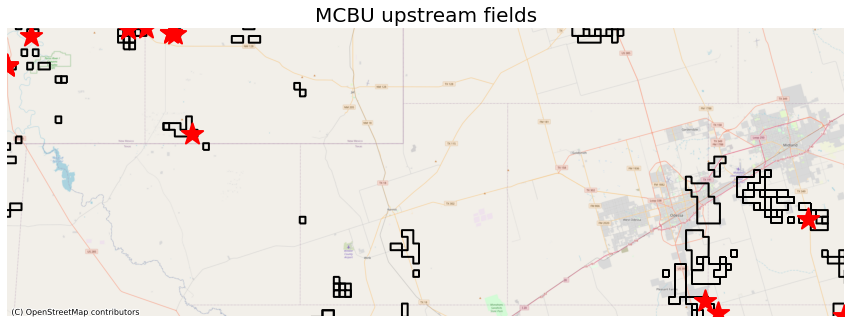

In [9]:
# Plot location map
fig, (ax) = plt.subplots(1, 1, figsize=(15, 20))

xlim = ([plumes_gdf_clipped.total_bounds[0],
         plumes_gdf_clipped.total_bounds[2]])
ylim = ([plumes_gdf_clipped.total_bounds[1],
         plumes_gdf_clipped.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

fields_gdf.plot(ax=ax,
                color='None',
                edgecolor='black',
                linewidth=2)

plumes_gdf_clipped.plot(ax=ax,
                       color='red',
                       marker='*',
                       markersize=500,
                       linewidth=2
                       )

cx.add_basemap(ax, crs=fields_gdf.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title(
    "MCBU upstream fields", fontsize=20)

ax.set_axis_off()